# Gemma-Information-Extraction

## Durchführung

Erstellung der Ausgabeklassen

In [1]:
from pydantic import BaseModel
from typing import Optional, List


class PersNameItem(BaseModel):
    PersName: Optional[List[str]] = None

class PlaceNameItem(BaseModel):
    PlaceName: Optional[List[str]] = None


`reisen02_filtered.json`, die zuvor in `corpus_creation.ipynb` erstellt wurde, wird als `input_json` definiert.
Jsons, die in den nachfolgenden Extraktions-Blöcken erstellt werden, werden gelöscht.

**Eventuelle zuvor generierte Ergebnisse sichern!**

In [2]:
import os

input_json = "reisen02_filtered.json"

# Dateien, die gelöscht werden sollen
files_to_delete = ["comparison_results.json", "place_results.json", "name_results.json"]

for file_name in files_to_delete:
    if os.path.exists(file_name):
        os.remove(file_name)
        print(f"{file_name} wurde gelöscht.")
    else:
        print(f"{file_name} existiert nicht.")

comparison_results.json existiert nicht.
place_results.json existiert nicht.
name_results.json existiert nicht.


### Personennamen-Extraktion

Auch hier haben zu viele Anweisungen nicht unbedingt zu einer Verbesserung der Ergebnisse geführt. Hier zwei Anweisungen, die wieder herausgenommen wurden, weil das nachträgliche Hinzufügen die Ausgabe eher verschlechtert hat.
    
    
    - Wenn du einen Satz nicht verstehst, gib eine leere Liste zurück. Das kann vor allem passieren, wenn der Satz nicht in deutscher Sprache ist.
    Beispiel:[
    "Satz": "Tonin wa okai iri naserrimas ka"
    "response":"PersName='None'"]

    - Berufsnamen, (Herrscher-)Titel und akademische Grade sind keine Personennamen.
    Beispiel:[
    "Satz": "Nachdem Capitain Morland auf dem Schiffe des Commandeurs das Zeichen gegeben hatte, stieß die Flotte in See."
    "response":"PersName='Morland'"]
    

In [4]:
import json
import ollama

# JSON-Datei laden
with open(input_json, "r", encoding="utf-8") as f:
    data = json.load(f)

sentences = data["sentences"]

results = []

# durch die Sätze iterieren
for sentence in sentences:
    # norm_text wird am Ende des Prompts an das Modell übergeben.
    norm_text = sentence["norm_sentence"]["text"]
    sentence_id = sentence["sentence_id"]
    tokens = sentence["norm_sentence"]["tokens"]

    # Prompt für das Modell erstellen
    prompt = f"""Du bist ein KI-Modell, das auf das Finden von Personennamen spezialisiert ist.
    Deine Aufgabe ist es, aus übergebenen Sätzen alle Personennamen zu extrahieren.
    Achte dabei auf folgendes:
    - Behalte die Originalschreibweise der Namen bei.
    Beispiel:[
        "Satz": "Die kurze Nachricht, welche de la Caille, der im Jahr 1751 nach Cap kam gibt, enthält beinahe nichts anderes, als was er von anderen hörte."
        "response":"PersName='de la Caille'"]
    - Extrahiere wirklich alle Personennamen, lasse keinen aus.
    Beispiel:[
        "Satz": "Unter Herrn Gronovius Mineralien fand ich viele Stufen aus Schweden, die Herr Gother ihm von seinem Gärtner Wittbom geschickt hatte."
        "response":"PersName='Gronovius', PersName='Gother', PersName='Wittbom'"]
    - Ignoriere alle andere Arten von Namen wie Ortsnamen und auch Berufsbezeichnungen, akademische Grade oder Titel.
    Beispiel:[
        "Satz": "Zu Leiden ließ ich mein erstes Geschäft sein, Herrn Professor van Royen zu besuchen, der mir seine kapsche Kräutersammlung zeigt, die er vom Grafen aus Ceylon bekommen hatte."
        "response":"PersName='van Royen'"]
    - Wenn du in einem Satz keine Namen findest, gib eine leere Liste zurück.
    Beispiel:[
        "Satz": "Er ist ein sehr artiger, aufgeweckter und gelehrter Mann."
        "response":"PersName='None'"]

    Satz: {norm_text}
    """

    # Modell aufrufen
    response = ollama.chat(
    model='gemma3:12b',
    messages=[
        {"role": "user",
         "content": prompt
        }
    ],
    format=PersNameItem.model_json_schema(),
    )

    name = PersNameItem.model_validate_json(response.message.content)
    print(f"Personennamen Satz {sentence_id}:  {response.message.content}")
    #print(name.PersName)

    extracted_names = []
    if name.PersName and name.PersName != "None":
        for name in name.PersName:
            # Splitte mehrteilige Begriffe und füge die Tokens zur Liste hinzu
            extracted_names.extend(name.split())

    results.append({"sentence_id": sentence_id, "extracted_names": extracted_names})

# Ergebnisse in eine JSON-Datei speichern
with open("name_results.json", "w", encoding="utf-8") as f:
    json.dump({"results": results}, f, ensure_ascii=False, indent=4)

print("Ergebnisse gespeichert in 'name_results.json'")

Personennamen Satz 0:  {"PersName": ["Karl Peter Thunberg"]}
Personennamen Satz 1:  {"PersName": ["Christian Heinrich Groskurd"]}
Personennamen Satz 2:  {"PersName": ["None"]}
Personennamen Satz 3:  {"PersName": ["None"]}
Personennamen Satz 4:  {"PersName": ["None"]}
Personennamen Satz 5:  {"PersName": ["None"]}
Personennamen Satz 6:  {"PersName": ["Kap", "Holland", "England", "Deutschland", "Schweden"]}
Personennamen Satz 7:  {"PersName": ["None"]}
Personennamen Satz 8:  {"PersName": ["None"]}
Personennamen Satz 9:  {"PersName": ["None"]}
Personennamen Satz 10:  {"PersName": ["None"]}
Personennamen Satz 11:  {"PersName": ["None"]}
Personennamen Satz 12:  {"PersName": ["None"]}
Personennamen Satz 13:  {"PersName": ["None"]}
Personennamen Satz 14:  {"PersName": ["None"]}
Personennamen Satz 15:  {"PersName": ["None"]}
Personennamen Satz 16:  {"PersName": ["None"]}
Personennamen Satz 17:  {"PersName": ["None"]}
Personennamen Satz 18:  {"PersName": ["None"]}
Personennamen Satz 19:  {"PersN

### Ortsnamenextraktion

In [6]:
# JSON-Datei laden
with open(input_json, "r", encoding="utf-8") as f:
    data = json.load(f)

sentences = data["sentences"]

results = []

# Schleife über alle normalisierten Sätze
for sentence in sentences:
    norm_text = sentence["norm_sentence"]["text"]
    sentence_id = sentence["sentence_id"]
    tokens = sentence["norm_sentence"]["tokens"]

    # Prompt für das Modell erstellen
    prompt = f"""Du bist ein KI-Modell, das auf das Finden von Orstnamen spezialisiert ist.
    Deine Aufgabe ist es, aus den übergebenen Sätzen alle Ortsnamen zu extrahieren.
    Achte dabei auf folgendes:
    - Behalte die Originalschreibweise der Namen bei.
    Beispiel:[
        "Satz": "Vom Keureboomsflusse reisten wir durch den Pußpaßfluss nach Zwellendam"
        "response":"PlaceName='Keureboomsflusse', PlaceName='Pußpaßfluss', PlaceName='Zwellendam'"]
    - Extrahiere wirklich alle Ortsnamen, lasse keinen aus.
    Beispiel:[
        "Satz": "Des Verfassers Reise von Stockholm nach dem Vorgebirge der guten Hoffnung, den ersten Aufenthalt zu Cap und die erste Reise nach Afrika."
        "response":"PlaceName='Stockholm', PlaceName='Vorgebirge der guten Hoffnung', PlaceName='Cap', PlaceName='Afrika'"]
    - Ignoriere alle andere Arten von Namen wie Personennamen.
    Beispiel:[
    "Satz": "Zu Leiden ließ ich mein erstes Geschäft sein, Herrn Professor van Royen zu besuchen, der mir seine kapsche Kräutersammlung zeigte."
    "response":"PlaceName='Leiden'"]
    - Wenn du in einem Satz keine Ortsnamen findest, gib eine leere Liste zurück.
        Beispiel:[
        "Satz": "Das Ufer ist sehr steil, springt oft in Landspitzen und Vorgebirgen vor."
        "response":"PersName='None'"]

    Satz: {norm_text}
    """

    # Modell aufrufen
    response = ollama.chat(
    model='gemma3:12b',
    messages=[
        {"role": "user",
         "content": prompt
        }
    ],
    format=PlaceNameItem.model_json_schema(),
    )

    name = PlaceNameItem.model_validate_json(response.message.content)
    print(response.message.content)
    #print(name.PersName)

    extracted_places = []
    if name.PlaceName and name.PlaceName != "None":
        for place in name.PlaceName:
            # Splitte mehrteilige Begriffe und füge die Tokens zur Liste hinzu
            extracted_places.extend(place.split())

    results.append({"sentence_id": sentence_id, "extracted_places": extracted_places})

# Ergebnisse in eine JSON-Datei speichern
with open("place_results.json", "w", encoding="utf-8") as f:
    json.dump({"results": results}, f, ensure_ascii=False, indent=4)

print("Ergebnisse gespeichert in 'place_results.json'")

{"PlaceName": ["Europa", "Afrika", "Asien", "Japan"]}
{"PlaceName": ["Stralsund"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Berlin", "Haude", "Spener"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Batavia", "Japan", "Dezime", "Jedo", "Ceylon", "Kap", "Holland", "England", "Deutschland", "Schweden"]}
{"PlaceName": ["Japan"]}
{"PlaceName": ["Japan"]}
{"PlaceName": ["Land"]}
{"PlaceName": ["None"]}
{"PlaceName": []}

{"PlaceName": []}
{"PlaceName": ["None"]}
{"PlaceName": ["Java", "Ceylon"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Stadt"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Stockholm", "Japan"]}
{"PlaceName": ["Upsala"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Stockholm"]}
{"PlaceName": ["None"]}
{"PlaceName": ["None"]}
{"PlaceName": ["Lund", "Upsala", "Stockholm", "Haarlem", 

## Erstellung Evaluations-Datei

Zunächst noch einmal die Überprüfung, wieviele Personen- und Ortsnamen im Text vorhanden sind.

In [61]:
import json

# JSON-Datei laden
input_json = "reisen02_filtered.json"
with open(input_json, "r", encoding="utf-8") as f:
    data = json.load(f)

# Initialisiere Zähler
total_person_names = 0
total_place_names = 0

# Schleife über alle Sätze
for sentence in data["sentences"]:
    tokens = sentence["norm_sentence"]["tokens"]
    
    # Zähle die Anzahl der Personen- und Ortsnamen
    total_person_names += sum(1 for token in tokens if token.get("entity_type") == "persName")
    total_place_names += sum(1 for token in tokens if token.get("entity_type") == "placeName")

# Ergebnisse ausgeben
print(f"Anzahl der Personennamen: {total_person_names}")
print(f"Anzahl der Ortsnamen: {total_place_names}")

Anzahl der Personennamen: 422
Anzahl der Ortsnamen: 1648


### Erstellung der Evaluationsdatei `comparison_results.json`.

Das Sprachmodell hat in vielen Fällen als leere Liste `None`, manchmal aber auch `[]`zurückgegben.

In [55]:
import json

# Funktion zum Zählen der "None"-Werte in einer JSON-Datei
def count_none_values(file_path, key):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    none_count = 0
    for result in data["results"]:
        none_count += sum(1 for item in result.get(key, []) if item == "None")
    
    return none_count

# Zähle "None"-Werte in place_results.json und name_results.json
place_none_count = count_none_values("place_results.json", "extracted_places")
name_none_count = count_none_values("name_results.json", "extracted_names")

# Ergebnisse ausgeben
print(f"Anzahl der 'None'-Werte in place_results.json: {place_none_count}")
print(f"Anzahl der 'None'-Werte in name_results.json: {name_none_count}")

Anzahl der 'None'-Werte in place_results.json: 3818
Anzahl der 'None'-Werte in name_results.json: 5609


Da im folgenden Code aber nur `[]`als leere Werte akzeptiert werden, müssen `None`-Strings ignoriert werden, da sie sonst die false-positives enorm in die Höhe treiben.
Die von dem LLM extrahierten Personennamen aus der name_results.json werden mit der Ground Truth in der `reisen02_filtered.json` verglichen.

Stimmen die Ergebnisse überein, wird der jeweilige Name in der Liste `hits`gespeichert. Ist der Name nur in der Ground Truth vorhanden, wird er in `missing` abgelegt.
Und wurde ein Name vom LLM identifiziert, der nicht in `reisen02_filtered.json` zu finden ist und der nicht `None`ist, wird er der `false_positive`-Liste hinzugefügt.

In [ ]:
# JSON-Dateien laden
with open(input_json, "r", encoding="utf-8") as f:
    test_data = json.load(f)

with open("name_results.json", "r", encoding="utf-8") as f:
    results_data = json.load(f)

# Ergebnisse speichern
comparison_results = []

# Schleife über alle Sätze in der test.json
for sentence in test_data["sentences"]:
    sentence_id = sentence["sentence_id"]
    tokens = sentence["norm_sentence"]["tokens"]

    # Extrahiere die persName-Tokens aus der test.json
    expected_names = [token["text"] for token in tokens if token.get("entity_type") == "persName"]

    # Finde die extrahierten Namen aus der results.json
    extracted_names = next((result["extracted_names"] for result in results_data["results"] if result["sentence_id"] == sentence_id), [])

    # Vergleich der Namen mit zusätzlichem Check
    hits = []
    missing = []
    false_positives = []

    for expected_name in expected_names:
        # Direkter Vergleich
        if expected_name in extracted_names:
            hits.append(expected_name)
        else:
            # Entferne den letzten Buchstaben und vergleiche erneut
            normalized_expected_name = expected_name[:-1] if len(expected_name) > 1 else expected_name
            match_found = False
            for extracted_name in extracted_names:
                if normalized_expected_name == extracted_name:
                    hits.append(extracted_name)  # Speichere den extrahierten Namen als Treffer
                    match_found = True
                    break
            if not match_found:
                missing.append(expected_name)

    # Falsch-positive Namen identifizieren
    # false positive sind Namen, die in `extracted_names` sind, aber nicht in `hits` und nicht "None"
    false_positives = [name for name in extracted_names if name not in hits and name != "None"]

    # Ergebnisse speichern
    comparison_results.append({
        "sentence_id": sentence_id,
        "persNames": {
            "hits": hits,
            "missing": missing,
            "false_positives": false_positives
        }
    })

# Vergleichsergebnisse speichern
with open("comparison_results.json", "w", encoding="utf-8") as f:
    json.dump(comparison_results, f, ensure_ascii=False, indent=4)

print("Vergleichsergebnisse gespeichert in 'comparison_results.json'")

Vergleichsergebnisse gespeichert in 'comparison_results.json'


Selbiges für die Ortsnamen durchgeführt und ebenfalls in der `comparison_results.json` gespeichert.

In [39]:
# JSON-Dateien laden
with open(input_json, "r", encoding="utf-8") as f:
    test_data = json.load(f)

with open("place_results.json", "r", encoding="utf-8") as f:
    results_data = json.load(f)

# Bestehende comparison_results.json laden
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Schleife über alle Sätze in der test.json
for sentence in test_data["sentences"]:
    sentence_id = sentence["sentence_id"]
    tokens = sentence["norm_sentence"]["tokens"]

    # Extrahiere die placeName-Tokens aus der test.json
    expected_names = [token["text"] for token in tokens if token.get("entity_type") == "placeName"]

    # Finde die extrahierten Namen aus der place_results.json
    extracted_names = next(
        (result["extracted_places"] for result in results_data["results"] if result["sentence_id"] == sentence_id),
        []
    )

    # Vergleich der Namen
    hits = [name for name in expected_names if name in extracted_names]
    missing = [name for name in expected_names if name not in extracted_names]
    false_positives = [name for name in extracted_names if name not in expected_names and name != "None"]

    # Ergebnisse in comparison_results.json ergänzen
    for result in comparison_results:
        if result["sentence_id"] == sentence_id:
            result["placeNames"] = {
                "hits": hits,
                "missing": missing,
                "false_positives": false_positives
            }
            break

# Vergleichsergebnisse speichern
with open("comparison_results.json", "w", encoding="utf-8") as f:
    json.dump(comparison_results, f, ensure_ascii=False, indent=4)

print("Vergleichsergebnisse in 'comparison_results.json' um Ortsnamen erweitert.")

Vergleichsergebnisse in 'comparison_results.json' um Ortsnamen erweitert.


## Evaluations-Skripte

### Ortsnamen

Das Ergebnis für die Ortsnamen:

In [42]:
import json

# JSON-Datei laden
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Initialisiere Zähler
total_hits = 0
total_missing = 0
total_false_positives = 0

# Schleife über alle Ergebnisse
for result in comparison_results:
    place_names = result.get("placeNames", {})
    total_hits += len(place_names.get("hits", []))
    total_missing += len(place_names.get("missing", []))
    total_false_positives += len(place_names.get("false_positives", []))

# Ergebnisse ausgeben
print("Kennzahlen für Ortsnamen:")
print(f"Treffer (Hits): {total_hits}")
print(f"Fehlende Namen (Missing): {total_missing}")
print(f"Falsch-positive Namen (False Positives): {total_false_positives}")

# Optional: Berechnung der Trefferquote
total_expected = total_hits + total_missing
if total_expected > 0:
    accuracy = (total_hits / total_expected) * 100
    print(f"Trefferquote: {accuracy:.2f}%")
else:
    print("Keine erwarteten Namen vorhanden.")

Kennzahlen für Ortsnamen:
Treffer (Hits): 1573
Fehlende Namen (Missing): 75
Falsch-positive Namen (False Positives): 2040
Trefferquote: 95.45%


Ausgabe als Balkendiagramm:

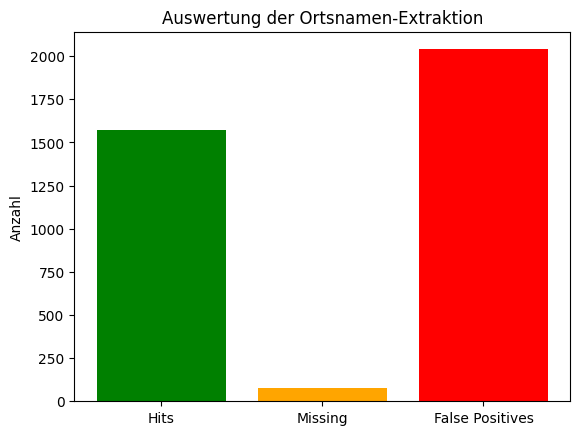

In [47]:
import matplotlib.pyplot as plt

# Bereinigung der Werte für False Positives
total_false_positives = sum(
    len([item for item in result.get("placeNames", {}).get("false_positives", []) if item != "None"])
    for result in comparison_results
)

# Daten für die Darstellung
categories = ["Hits", "Missing", "False Positives"]
values = [total_hits, total_missing, total_false_positives]

# Balkendiagramm erstellen
plt.bar(categories, values, color=["green", "orange", "red"])
plt.title("Auswertung der Ortsnamen-Extraktion")
plt.ylabel("Anzahl")
plt.show()

Ein Ranking der 30 häufigsten `false-positive`-Strings:

In [58]:
import json
from collections import Counter

# JSON-Datei laden
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Alle False-Positive-Strings sammeln
false_positives = []

for result in comparison_results:
    place_names = result.get("placeNames", {})
    false_positives.extend(place_names.get("false_positives", []))

# Entferne leere Strings und None-Werte aus der Liste
false_positives = [item for item in false_positives if item and item.strip()]

# Häufigkeit der False-Positive-Strings berechnen
false_positive_counts = Counter(false_positives)

# Ranking erstellen (sortiert nach Häufigkeit)
ranking = false_positive_counts.most_common()

# Ranking ausgeben
print("Ranking der Ortsnamen-False-Positive-Strings:")
for string, count in ranking[0:30]:
    print(f"{string}: {count} Vorkommen")

Ranking der Ortsnamen-False-Positive-Strings:
Japan: 113 Vorkommen
Japaner: 110 Vorkommen
Stadt: 52 Vorkommen
Ceylon: 32 Vorkommen
Dairi: 30 Vorkommen
Holländer: 29 Vorkommen
Java: 29 Vorkommen
China: 28 Vorkommen
Insel: 25 Vorkommen
Japanische: 21 Vorkommen
Afrika: 17 Vorkommen
Lande: 17 Vorkommen
Norimon: 17 Vorkommen
Kubo: 17 Vorkommen
Faktorei: 16 Vorkommen
Städten: 16 Vorkommen
Chinesen: 15 Vorkommen
Bergen: 14 Vorkommen
Holländern: 13 Vorkommen
Berge: 13 Vorkommen
Japanern: 11 Vorkommen
Compagnie: 11 Vorkommen
Malabar: 11 Vorkommen
Küste: 10 Vorkommen
Hafen: 10 Vorkommen
Chinese: 10 Vorkommen
Provinz: 10 Vorkommen
Europa: 10 Vorkommen
Holländische: 10 Vorkommen
Holländischen: 9 Vorkommen


Skript, das die zu den False-Positive_Strings gehörigen Sätze ausgibt.
String kann mit Variable `top_false_positive` angepasst werden.

In [93]:
import json

# JSON-Dateien laden
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

with open("reisen02_filtered.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

# Manuell den False-Positive-Ortsnamen setzen
top_false_positive = "Hafen"  # Ersetze diesen Wert durch den gewünschten Ortsnamen

# Alle Sätze finden, in denen der False-Positive-Ortsname vorkommt
sentences_with_top_false_positive = []

for result in comparison_results:
    sentence_id = result["sentence_id"]
    place_names = result.get("placeNames", {})
    if top_false_positive in place_names.get("false_positives", []):
        # Lade den Satz aus der Originaldatei
        sentence = next((s["norm_sentence"]["text"] for s in test_data["sentences"] if s["sentence_id"] == sentence_id), "Satz nicht gefunden")
        sentences_with_top_false_positive.append({"sentence_id": sentence_id, "sentence": sentence})

# Ergebnisse ausgeben
print(f"Alle Sätze mit dem False-Positive-Ortsnamen '{top_false_positive}':")
for entry in sentences_with_top_false_positive:
    print(f"Sentence ID: {entry['sentence_id']}, Satz: {entry['sentence']}")

Alle Sätze mit dem False-Positive-Ortsnamen 'Hafen':
Sentence ID: 246, Satz: Hafen von Nagasaki.
Sentence ID: 427, Satz: Hafen.
Sentence ID: 763, Satz: Das letzte war das mit uns abgegangene zweite Schiff, das so schadhaft geworden war, daß es in einen Chinesischen Hafen einlaufen mußte, wo es ausgebessert wurde, und von da es nach Batavia zurück segelte.
Sentence ID: 962, Satz: Ebbe und Flut ist im Hafen sehr stark.
Sentence ID: 978, Satz: Die Stadt selbst ist auf allen Seiten landwärts mit hohen, nach dem Hafen sich herab senkenden Bergen umgeben, und von ganz ansehnlichem Umfange.
Sentence ID: 981, Satz: Durch die Stadt gehen einige Kanäle, die das Wasser von den umliegenden Bergen sammeln und ableiten, und sich ganz bis zum Hafen herab erstrecken.
Sentence ID: 5468, Satz: Hafen zu Gale.
Sentence ID: 5545, Satz: Die Städte, wo solche Fürsten ihre Hofhaltung haben, sind meistens von bedeutender Größe, liegen an einem Hafen oder großen Flusse, und sind mit Wall und Graben umgeben.
Sen

Ausgabe der Sätze mit höchster Fehlerzahl.

In [63]:
# Sätze mit den meisten Fehlern finden
error_analysis = []

for result in comparison_results:
    sentence_id = result["sentence_id"]
    place_names = result.get("placeNames", {})
    total_errors = len(place_names.get("missing", [])) + len(place_names.get("false_positives", []))
    error_analysis.append((sentence_id, total_errors))

# Sortiere nach Fehleranzahl
error_analysis.sort(key=lambda x: x[1], reverse=True)

# Top 5 Sätze mit den meisten Fehlern ausgeben
print("Top 5 Sätze mit den meisten Fehlern:")
for sentence_id, errors in error_analysis[:5]:
    # Lade den Satz aus der Originaldatei
    sentence = next((s["norm_sentence"]["text"] for s in test_data["sentences"] if s["sentence_id"] == sentence_id), "Satz nicht gefunden")
    extracted_places = next((r["extracted_places"] for r in results_data["results"] if r["sentence_id"] == sentence_id), [])
    
    print(f"Sentence ID: {sentence_id}, Fehler: {errors}")
    print(f"Satz: {sentence}")
    print(f"Extrahierte Ortsnamen: {extracted_places}\n")

Top 5 Sätze mit den meisten Fehlern:
Sentence ID: 223, Fehler: 123
Satz: Inhalt.
Extrahierte Ortsnamen: ['München', 'Berlin', 'Hamburg', 'Leipzig', 'Dresden', 'München', 'Nürnberg', 'Frankfurt', 'Köln', 'Stuttgart', 'Düsseldorf', 'Dortmund', 'Essen', 'Bremen', 'Dresden', 'Halle', 'Magdeburg', 'Kiel', 'Rostock', 'Stralsund', 'Wismar', 'Schwerin', 'Erfurt', 'Weimar', 'Jena', 'Potsdam', 'Bonn', 'Mannheim', 'Wiesbaden', 'Münster', 'Bielefeld', 'Chemnitz', 'Karlsruhe', 'Braunschweig', 'Krefeld', 'Freiburg', 'Mainz', 'Lübeck', 'Augsburg', 'Wuppertal', 'Hannover', 'Duisburg', 'Bochum', 'Würzburg', 'Oldenburg', 'Erfurt', 'Regensburg', 'Gotha', 'Pforzheim', 'Saarbrücken', 'Wolfsburg', 'Kassel', 'Hildesheim', 'Mönchengladbach', 'Luxemburg', 'Belgien', 'Niederlande', 'Österreich', 'Schweiz', 'Tschechien', 'Polen', 'Frankreich', 'Italien', 'Spanien', 'Portugal', 'Griechenland', 'Rumänien', 'Bulgarien', 'Ungarn', 'Slowakei', 'Kroatien', 'Serbien', 'Albanien', 'Türkei', 'Russland', 'Ukraine', 'Weißr

### Personennamen

Das Ergebnis für die Ortsnamen:

In [81]:
import json

# JSON-Datei laden
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Initialisiere Zähler
total_hits = 0
total_missing = 0
total_false_positives = 0

# Schleife über alle Ergebnisse
for result in comparison_results:
    pers_names = result.get("persNames", {})
    total_hits += len(pers_names.get("hits", []))
    total_missing += len(pers_names.get("missing", []))
    total_false_positives += len(pers_names.get("false_positives", []))

# Ergebnisse ausgeben
print("Kennzahlen für Personennamen:")
print(f"Treffer (Hits): {total_hits}")
print(f"Fehlende Namen (Missing): {total_missing}")
print(f"Falsch-positive Namen (False Positives): {total_false_positives}")

# Optional: Berechnung der Trefferquote
total_expected = total_hits + total_missing
if total_expected > 0:
    accuracy = (total_hits / total_expected) * 100
    print(f"Trefferquote: {accuracy:.2f}%")
else:
    print("Keine erwarteten Namen vorhanden.")

Kennzahlen für Personennamen:
Treffer (Hits): 394
Fehlende Namen (Missing): 28
Falsch-positive Namen (False Positives): 885
Trefferquote: 93.36%


Grafische Darstellung:

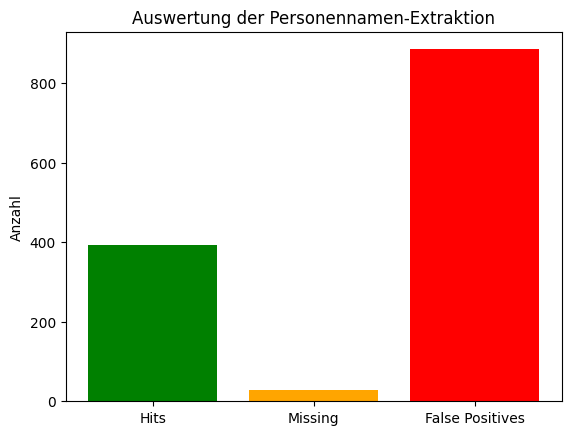

In [82]:
import matplotlib.pyplot as plt

# Daten für die Darstellung
categories = ["Hits", "Missing", "False Positives"]
values = [total_hits, total_missing, total_false_positives]

# Balkendiagramm erstellen
plt.bar(categories, values, color=["green", "orange", "red"])
plt.title("Auswertung der Personennamen-Extraktion")
plt.ylabel("Anzahl")
plt.show()

Ein Ranking der 30 häufigsten `false-positive`-Strings:

In [86]:
import json
from collections import Counter

# JSON-Datei laden
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

# Alle False-Positive-Strings sammeln
false_positives = []

for result in comparison_results:
    place_names = result.get("persNames", {})
    false_positives.extend(place_names.get("false_positives", []))

# Häufigkeit der False-Positive-Strings berechnen
false_positive_counts = Counter(false_positives)

# Ranking erstellen (sortiert nach Häufigkeit)
ranking = false_positive_counts.most_common()

# Ranking ausgeben
print("Ranking der Personennamen-False-Positive-Strings:")
for string, count in ranking[0:30]:  # Top 10 Ergebnisse
    print(f"{string}: {count} Vorkommen")

Ranking der Personennamen-False-Positive-Strings:
Kubo: 21 Vorkommen
Dairi: 15 Vorkommen
Jedo: 14 Vorkommen
Kaiser: 14 Vorkommen
Gouverneur: 11 Vorkommen
Kapitän: 10 Vorkommen
Simonoseki: 8 Vorkommen
Ambassadeur: 8 Vorkommen
Juana: 8 Vorkommen
Kronprinz: 6 Vorkommen
Chef: 6 Vorkommen
Ottone: 6 Vorkommen
Dezime: 5 Vorkommen
Miako: 5 Vorkommen
Kronprinzen: 5 Vorkommen
Curundu: 5 Vorkommen
P.: 4 Vorkommen
Kapitäns: 4 Vorkommen
von: 4 Vorkommen
Papenberg: 4 Vorkommen
Resp.: 3 Vorkommen
Mia: 3 Vorkommen
Sekretär: 3 Vorkommen
Fürsten: 3 Vorkommen
der: 3 Vorkommen
Seki: 3 Vorkommen
Batavia: 3 Vorkommen
Gale: 3 Vorkommen
Kaneel: 3 Vorkommen
Dai: 3 Vorkommen


Skript, das die zu den False-Positive_Strings gehörigen Sätze ausgibt.
String kann mit Variable `top_false_positive` angepasst werden.

In [91]:
import json

# JSON-Dateien laden
with open("comparison_results.json", "r", encoding="utf-8") as f:
    comparison_results = json.load(f)

with open("reisen02_filtered.json", "r", encoding="utf-8") as f:
    test_data = json.load(f)

# Manuell den False-Positive-Namen setzen
top_false_positive = "Jedo"  # Ersetze diesen Wert durch den gewünschten Namen

# Alle Sätze finden, in denen der False-Positive-String vorkommt
sentences_with_top_false_positive = []

for result in comparison_results:
    sentence_id = result["sentence_id"]
    pers_names = result.get("persNames", {})
    if top_false_positive in pers_names.get("false_positives", []):
        # Lade den Satz aus der Originaldatei
        sentence = next((s["norm_sentence"]["text"] for s in test_data["sentences"] if s["sentence_id"] == sentence_id), "Satz nicht gefunden")
        sentences_with_top_false_positive.append({"sentence_id": sentence_id, "sentence": sentence})

# Ergebnisse ausgeben
print(f"Alle Sätze mit dem False-Positive-Personennamen '{top_false_positive}':")
for entry in sentences_with_top_false_positive:
    print(f"Sentence ID: {entry['sentence_id']}, Satz: {entry['sentence']}")

Alle Sätze mit dem False-Positive-Personennamen 'Jedo':
Sentence ID: 346, Satz: Reise von Dezime nach Jedo.
Sentence ID: 1337, Satz: Reise von Dezime nach der Kaiserlichen Residenz-Stadt Jedo.
Sentence ID: 1608, Satz: Bei Jokaits waren wir wieder an der Küste, in deren Nähe wir hernach fast ganz hin bis Jedo blieben.
Sentence ID: 1760, Satz: Unsere letzte Tagereise machten wir den 27. April, da wir ungefähr zehn Meilen bis Jedo hatten.
Sentence ID: 1996, Satz: Ehe ich mich von Jedo trennte, konnte ich nicht umhin, zu erfahren zu suchen, teils was wenige Japaner selbst erfahren, den Namen des Monarchen, dessen Hof zu besuchen ich die seltene Ehre genossen hatte; teils die Namen der sämtlichen, so wohl geistlichen als weltlichen Regenten, welche seit Kämpfers Zeit dies gesegnete Land, dies glückliche Volk beherrscht haben.
Sentence ID: 2072, Satz: Zwischen Jedo und Miako sahen wir hie und da an den Landstraßen Bettler, die, und zwar meistens an den Füßen, gebrechlich waren.
Sentence ID: 

Ausgabe der Sätze mit höchster Fehlerzahl.

In [84]:
# JSON-Dateien laden
with open("name_results.json", "r", encoding="utf-8") as f:
    results_data = json.load(f)

# Sätze mit den meisten Fehlern für Personennamen finden
error_analysis = []

for result in comparison_results:
    sentence_id = result["sentence_id"]
    pers_names = result.get("persNames", {})
    total_errors = len(pers_names.get("missing", [])) + len(pers_names.get("false_positives", []))
    error_analysis.append((sentence_id, total_errors))

# Sortiere nach Fehleranzahl
error_analysis.sort(key=lambda x: x[1], reverse=True)

# Top 5 Sätze mit den meisten Fehlern ausgeben
print("Top 5 Sätze mit den meisten Fehlern für Personennamen:")
for sentence_id, errors in error_analysis[:5]:
    # Lade den Satz aus der Originaldatei
    sentence = next((s["norm_sentence"]["text"] for s in test_data["sentences"] if s["sentence_id"] == sentence_id), "Satz nicht gefunden")
    extracted_names = next((r["extracted_names"] for r in results_data["results"] if r["sentence_id"] == sentence_id), [])
    
    print(f"Sentence ID: {sentence_id}, Fehler: {errors}")
    print(f"Satz: {sentence}")
    print(f"Extrahierte Personennamen: {extracted_names}\n")

Top 5 Sätze mit den meisten Fehlern für Personennamen:
Sentence ID: 7100, Fehler: 126
Satz: Hier sind ihre Namen: der japanische und der Vielfleck-Sonnenkäfer ( Coccinella japonica, quadripustulata ); das Sonnenhähnchen und das Weidenhähnchen ( Chrysomela aestuans, pallida ); der Totenfreund ( Dermestes violaceus ); der Japanische- und der Ketten-Sandläufer ( Cicindela japonica, catena ); der Kupferschmied ( Scarabaeus aeruginosus, japanisch Fama Musi ); der europäische Dungkäfer ( Hefter unicolor ); der großnasige Erdfloh und der Stachelfloh ( Mordella nasuta, aculeata ); der Kräuterdieb ( Ptinus für ); der Zwitterkäfer ( Malve proscarabaeus ); der Blaustrich und der Blasenschildkäfer ( Cassida nobilis, vesicularis ); der Blumenkratzer aus dem Geschlecht der Totengräber ( Sylpha aestiva ); der Bauer, die Feuerglut, der zierliche und der Haubenstinkkäfer ( Buprestis rustica, ignita, elegans, vittata ); das Stachelhorn ( Cerambyx rubus ); der japanische und der platte leuchtende Käfer (

1598 sind Beispielsweise sowohl als Place-, als auch PersNames identifiziert worden. So handelt es sich korrekt um Namen, aber um die falsche Gattung von Namen.
Auch bei 1633 der Fall.

Und auch bei 1648 wobei hier sogra 20 Ortsnamen korrekt extrahiert wurden und nur 15 Personennamen falsch. Anscheinend wurden also manche Namen korrekt als Orte identifiziert, bzw. nicht als Personennamen.

Vermutung liegt auch dadurch Nahe, da die 5 Namen an unterschiedlichen Stellen in der Liste fehlen und nicht einfach am Ende weggelassen wurden, weil z.b. der Arbeitsspeicher ausgegangen ist.
